In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_pinball_loss, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression

In [2]:
train_data = pd.read_csv("train.csv", delimiter=",")
test_data = pd.read_csv("test.csv", delimiter=",")

In [3]:
train_data.head()

,invoice_number,product_id,product_description,quantity,date,product_price,customer,state,product_class,operational_unit
0,a7b395be-8b16-4312-9782-890e75e6e385,7dd89457-557f-4d8a-99de-76d35bff0ea4,FELTCRAFT DOLL ROSIE,6,2011-07-08T10:23:00Z,2.95,00014495-b8ab-42fc-9ac8-51392ab44aa0,Florida,B,1
1,a7b395be-8b16-4312-9782-890e75e6e385,cf3fb78b-9cf7-41fc-9c09-0f83e2829e23,DOORMAT NEW ENGLAND,6,2011-07-08T10:23:00Z,7.95,00014495-b8ab-42fc-9ac8-51392ab44aa0,Florida,A,1
2,a7b395be-8b16-4312-9782-890e75e6e385,ded3c4f6-706f-4093-aefd-65cbafed12e2,ALARM CLOCK BAKELIKE GREEN,4,2011-07-08T10:23:00Z,3.75,00014495-b8ab-42fc-9ac8-51392ab44aa0,Florida,B,1
3,a7b395be-8b16-4312-9782-890e75e6e385,9fea4a62-84a0-4a92-9aa6-af21431a2de5,EMERGENCY FIRST AID TIN,12,2011-07-08T10:23:00Z,1.25,00014495-b8ab-42fc-9ac8-51392ab44aa0,Florida,C,1
4,a7b395be-8b16-4312-9782-890e75e6e385,2ec06d3b-d12a-4d29-bf1b-721583f34b10,DOORMAT RED RETROSPOT,6,2011-07-08T10:23:00Z,7.95,00014495-b8ab-42fc-9ac8-51392ab44aa0,Florida,A,1


1. We verify outliers, negatives values and dispersion in the variables. And, do changes to format to finally exclude columns that we don't use

In [4]:
train_data.loc[:,['quantity']]

,quantity
0,6
1,6
2,4
3,12
4,6
...,...
411209,4
411210,2
411211,1
411212,2


In [5]:
# train_data.boxplot() =====> Boxplot to see quckly distribution and outliers.
train_data.loc[train_data["quantity"] < 0]
train_data.loc[
    (train_data["product_description"] != "Discount") & (train_data["quantity"] < 0)
]
# train_data.describe() =====> To see current variables and its respective statistical metrics.

# --- We change the format of the column "date" and drop the columns that we won't use --- 
train_data["date"] = pd.to_datetime(train_data["date"], format=r"%Y-%m-%d").dt.date
train_data["date"] = pd.to_datetime(train_data["date"])
train_df = train_data.drop(
    [
        "invoice_number",
        "customer",
        "product_id",
        "product_description",
        "state",
        "product_price",
    ],
    axis=1)

test_data["date"] = pd.to_datetime(test_data["date"], format=r"%Y-%m-%d").dt.date
test_data["date"] = pd.to_datetime(test_data["date"])
test_df = test_data.drop(
    [
        "invoice_number",
        "customer",
        "product_id",
        "product_description",
        "state",
        "product_price",
    ],
    axis=1)


2. We use intercuartilic range to discriminate outliers, excluding negatives quantities. (11+1,5*(11-10)) = 26 we took this result as superior limit.


In [6]:
"We exclude around 9000 negative observations in 'quantity field' and in the product_description some observatios detailed as discount."

# --- We proceed to set the new dataset including restrictions to clean the data ---
train_data=train_data.loc[(train_df["quantity"] > 0) & (train_df["quantity"] < 27)]
train_df = train_df.loc[(train_df["quantity"] > 0) & (train_df["quantity"] < 27)]

train_df.isna().sum()
train_df = train_df.dropna()

3. We transform Train and Test datasets applying one-hot encoding to create artificial variables

In [7]:
# --- Independent variable selected (FEATURES), will be "product_class" ---
train_df = (
    pd.get_dummies(train_df, columns=["product_class"])
    .sort_values(by="date")
    .drop(["operational_unit"], axis=1)
)

# --- We deleted from dataframe "test_data" the columns that aren't in the "train_data" to get the same dimensionality ---
test_df = (
    pd.get_dummies(test_df, columns=["product_class"])
    .sort_values(by="date")
    .drop(["operational_unit"], axis=1)
)


4. We create a function to extract the date and split in years, month, days and weeks to get more characteristics.

In [8]:
def extraer_fechas(df):
    """
    Returns a dataframe with the date splitted by year,month,day and week.

        Parameters:
            df (Dataframe): A dataframe Pandas Object

        Returns:
            df (Dataframe): Configured dataframe with new columns of a splitted date
    """
    df = df.set_index(df.date)
    df.drop(["date"], axis=1, inplace=True)

    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["week"] = pd.Index(df.index.isocalendar().week)
    df.reset_index(drop=True, inplace=True)

    return df


test_df = extraer_fechas(test_df)
train_df = extraer_fechas(train_df)


5. We create a functions to compare the results of MSE for each tested model  

In [9]:
# we defined a dictionary that will store MSE comparisons returned by the function "compare_results"
results_dict = {}
FEATURES = list(train_df.columns[1:])
PREDICT_VAR = "quantity"

def compare_results():
    """
    Returns the comparison between the MSE of each model inside the "results_dict" dictionary.

        Parameters:
            (none): none

        Returns:
            results_dict (dict): Medium Squared Error of the prediction model stored
    """

    for key in results_dict:

        print("Supervised: ", key)
        print()

        print("Training data")
        for metric in results_dict[key]["training"]:
            print(metric, results_dict[key]["training"][metric])
        print()

        print("Test data")
        for metric in results_dict[key]["test"]:
            print(metric, results_dict[key]["test"][metric])
        print()


6. Function that give the result of MSE

In [10]:
def summarize_prediction(y_true, y_pred):
    """
    Returns the mean squared error (MSE) between the true dependent "y" variable and predict "y" variable.

        Parameters:
            y_true (Series): A pandas.core.series.Series object
            y_pred (Series): A pandas.core.series.Series object

        Returns:
            r_squared (float): A float number between 0-1, represent the nearness of regression line respect to points
            error_mse (float): A float number, mean of the error squared
    """
    r_squared = r2_score(y_true, y_pred)
    error_mse = mean_squared_error(y_true, y_pred)
    pinball_loss = mean_pinball_loss(y_true, y_pred)

    return {
        "R2: ": " %.2f" % r_squared,
        "MSE: ": " %.2f" % error_mse,
        "Pinball Loss: ": "%.2f" % pinball_loss,
    }


7. We evaluate every model to select which returns the better performance based on MSE metric

In [11]:
def build_model(predict_function, name_of_y_col, names_of_x_cols, df):
    """
    Returns the train  and test summary, the called to function "summarize_prediction".

        Parameters:
            predict_function (object): Fitted model, predictor object
            name_of_y_col (Series): A pandas.core.series.Series object
            names_of_x_cols (Series): A pandas.core.series.Series object
            df (Dataframe): A Dataframe pandas object

        Returns:
            train_summary (float): A float number, mean of the error squared calculated with the difference between real "y" and predicted "y"
    """
    x = df[names_of_x_cols]
    y = df[name_of_y_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = predict_function(x_train, y_train)

    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train) 

    train_summary = summarize_prediction(y_train, y_pred_train)
    test_summary = summarize_prediction(y_test, y_pred)

    return {"training": train_summary, "test": test_summary}


8. We defined all the functions that will be a possible solution

In [12]:
# ==== Model 1 linear Regression ====
def lin_regression(x_train, y_train):

    lin_r = make_pipeline(
        StandardScaler(with_mean=False), LinearRegression()
    )  # an error occurred after use only LinearRegression(), the output suggest use make_pipeline
    model = lin_r.fit(x_train, y_train)

    return model


# ==== Model 2 Bayesian Ridge Regression ====
def bayes_ridge(x_train, y_train):

    bys_ridge = BayesianRidge(n_iter=1000000, tol=1e-6)
    model = bys_ridge.fit(x_train, y_train)

    return model

# ==== Model 3 Bayesian ARD Regression ====
def ardr_regression(x_train, y_train):

    Areldet_regression = ARDRegression(n_iter=1000000, tol=1e-6)
    model = Areldet_regression.fit(x_train, y_train)

    return model


9. We add all models into dict "results_dict" and call the function "compare_results" to compare the results obtained

In [13]:
results_dict["Bayesian Ridge ~ Regression"] = build_model(
    bayes_ridge, PREDICT_VAR, FEATURES, train_df
)


results_dict["linear ~ Regression"] = build_model(
    lin_regression, PREDICT_VAR, FEATURES, train_df
)

results_dict["Bayesian ARD ~ Regression"] = build_model(
    ardr_regression, PREDICT_VAR, FEATURES, train_df
)

compare_results()


Supervised:  Bayesian Ridge ~ Regression

Training data
R2:   0.17
MSE:   33.17
Pinball Loss:  2.13

Test data
R2:   0.17
MSE:   33.41
Pinball Loss:  2.13

Supervised:  linear ~ Regression

Training data
R2:   0.17
MSE:   33.36
Pinball Loss:  2.13

Test data
R2:   0.17
MSE:   32.65
Pinball Loss:  2.11

Supervised:  Bayesian ARD ~ Regression

Training data
R2:   0.17
MSE:   33.01
Pinball Loss:  2.12

Test data
R2:   0.17
MSE:   34.04
Pinball Loss:  2.15



10. The selected model and the prediction with the test_data


In [14]:
def model_selected(predict_function, name_of_y_col, names_of_x_cols, df_test, df_train):
    """
    Returns the final prediction with the selected model.

        Parameters:
            predict_function (object): Fitted model, predictor object
            name_of_y_col (Series): A pandas.core.series.Series object
            names_of_x_cols (Series): A pandas.core.series.Series object
            df_test (Dataframe): A Dataframe pandas object
            df_train (Dataframe): A Dataframe pandas object

        Returns:
            y_prediction (Series): A pandas.core.series.Series object, column with the predicition values for the dates and predictor variables passed.
    """
    X_test = df_test[names_of_x_cols]

    Y_train = df_train[name_of_y_col]
    X_train = df_train[names_of_x_cols]

    model = predict_function(X_train, Y_train)
    y_prediction = model.predict(X_test)

    return y_prediction


11. We saved the prediction in the csv file.

In [15]:
# We add the prediction to the test dataset.
test_data["predicciones"] = model_selected(
    lin_regression, PREDICT_VAR, FEATURES, test_df, train_df
)

train_data["predicciones"] = model_selected(
    lin_regression, PREDICT_VAR, FEATURES, train_df, train_df
)

# Resampling the dataset to let it as weekly.
test_data_weekly = test_data.resample("W", on="date").sum().sort_values(by="date")
train_data_weekly = train_data.resample("W", on="date").sum().sort_values(by="date")
# test_data_weekly =====> RESULTADO DE PREDICCIÓN SEMANAL

# Return the date index as column.
test_data_weekly["date"] = test_data_weekly.index
train_data_weekly["date"] = train_data_weekly.index

'''#We apply format to the predictions and save in csv file.
test_data.predicciones = np.round(test_data.predicciones, 2)
test_data.to_csv(
    r"C:/Users/bbarruecou/Desktop/Desafío Data Scientist BRAIN FOOD/test.csv",
    index=False,
)
'''

'#We apply format to the predictions and save in csv file.\ntest_data.predicciones = np.round(test_data.predicciones, 2)\ntest_data.to_csv(\n    r"C:/Users/bbarruecou/Desktop/Desafío Data Scientist BRAIN FOOD/test.csv",\n    index=False,\n)\n'

12. We Graph the prediction

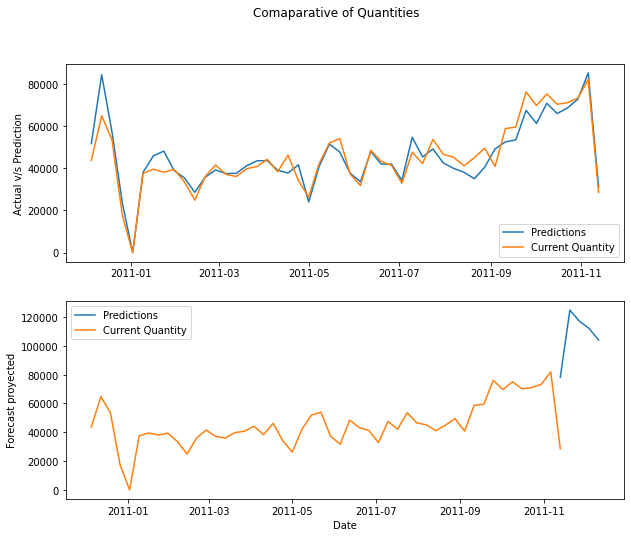

In [16]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("Comaparative of Quantities")

ax1.plot(train_data_weekly["predicciones"], label="Predictions")
ax1.plot(train_data_weekly["quantity"], label="Current Quantity")
ax1.legend()
ax1.set_ylabel("Actual v/s Prediction")

ax2.plot(test_data_weekly["predicciones"], label="Predictions")
ax2.plot(train_data_weekly["quantity"], label="Current Quantity")
ax2.legend()
ax2.set_xlabel("Date")
ax2.set_ylabel("Forecast proyected")

plt.show()
